In [1]:
import numpy as np 
import scipy.stats as sp 
import matplotlib.pyplot as plt 

$$L(\alpha,\delta | y_i,t_i) \propto -nlog(1+e^\delta)-\frac{\alpha^2}{2\sigma^2}-\frac{\delta^2}{2\tau^2} + \sum_{i,y_i=0}log(e^\delta +(1+e^\alpha)^{-t_i}) + \alpha \sum_{i, y_i \ne 0}y_i - log(1+e^\alpha) \sum_{i,y_i\ne 0}t_i$$

In [2]:
#sd_param = [sd_alpha, sd_delta] -> param to disturb alpha and delta to build a candidate
#sigma & tau -> sd of alpha and delta as defined in their normal distributions
def heartbeats(sigma, tau, sd_param, nchain, hearts_data):
    #2 parameters to estimate 
    chain = np.zeros((nchain+1, 2)) #alpha and delta 
    #init at 0,0 (told so in the data folder) --> p = 0.5 and theta = 0.5
    
    #rate of acceptance
    acceptance = 0
    
    #data
    t = hearts_data[:, 0] #total
    x = hearts_data[:, 1] #before drug
    y = hearts_data[:, 2] #after drug
    
    #log density 
    def log_g(alpha, delta, t, x, y, sigma, tau):
        N = len(t) #total number of observations
        
        idx0 = np.where(y ==0) #vector that indicates the value where there is no PVC's after drug
        idx1 = np.where(y !=0)
        
        y0 = y[idx0] #yi where yi=0
        y1 = y[idx1] #yi where yi!=0
        t0 = t[idx0] #ti where yi=0
        t1 = t[idx1] #ti where yi!=0
        #n0 = y0.sum() 
        #n1 = (y1).sum()
        
        sum1 = - N*np.log(1+np.exp(delta)) - ((alpha/sigma)**2 + (delta/tau)**2)/2
        
        #part where yi=0
        sum2 = (np.log(np.exp(delta)+(1+np.exp(alpha))**(-t0))).sum()
        
        #part where yi!=0
        sum3 = (alpha*y1).sum() - np.log(1+np.exp(alpha))*t1.sum()
    
        return sum1+sum2+sum3
    
    for i in range(nchain):
        index = np.random.choice([0,1]) #random index to change randomly alpha or delta 
        
        prop = chain[i,:]##np.zeros(2) #building the proposition
        prop[index] = chain[i, index] + np.random.normal(scale = sd_param[index]) #candidate
        ##prop[abs(1-index)] = chain[i, abs(1-index)] #coordinate we don't change here

        #proposal kernel symetric --> only the difference between the log-densities 
        ratio = log_g(prop[0], prop[1], t, x, y, sigma, tau) - \
                log_g(chain[i,0], chain[i,1], t, x, y, sigma, tau)
        ratio = np.exp(ratio)
        
        #even if we don't accept the candidate, we need to put everyone from i to i+1
        chain[i+1,:] = chain[i,:]
        
        #update
        if np.random.uniform() < ratio: 
            chain[i+1,:] = prop
            acceptance += 1
        
        #using the inverse of logit to get p and theta ? 
        
    return chain, acceptance/nchain

In [3]:
#number of individual 
N = 12
#PVC total count 
t = np.array([11, 11, 17, 22, 9, 6, 5, 14, 9, 7, 22, 51])

#before drugs 
x = np.array([6, 9, 17, 22, 7, 5, 5, 14, 9, 7, 9, 51])

#after drugs 
y = np.array([5, 2, 0, 0, 2, 1, 0, 0, 0, 0, 13, 0])

heats = np.vstack((t,x,y))
hearts = heats.T
hearts

array([[11,  6,  5],
       [11,  9,  2],
       [17, 17,  0],
       [22, 22,  0],
       [ 9,  7,  2],
       [ 6,  5,  1],
       [ 5,  5,  0],
       [14, 14,  0],
       [ 9,  9,  0],
       [ 7,  7,  0],
       [22,  9, 13],
       [51, 51,  0]])

In [6]:
#how much we disturb alpha and delta
sd_alpha = 1
sd_delta = 1

#sd of alpha and delta -> 10000 in the doc ?
sigma = 10000
tau = 10000

sd_param = np.array([sd_alpha, sd_delta])

chain, accep = heartbeats(sigma, tau, sd_param, 11000, heats)

In [7]:
print(accep)

1.0


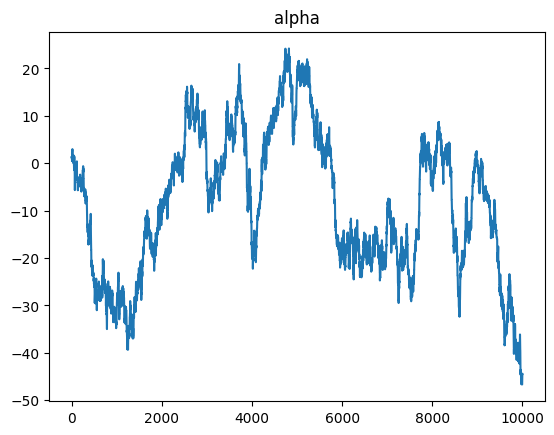

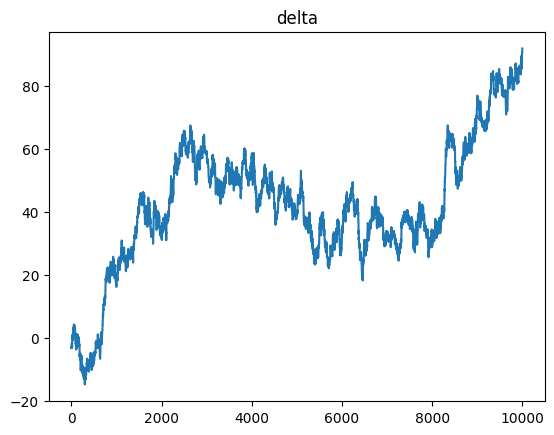

In [8]:
plt.plot(chain[1000:, 0])
plt.title("alpha")
plt.show()
plt.plot(chain[1000:, 1])
plt.title("delta")
plt.show()

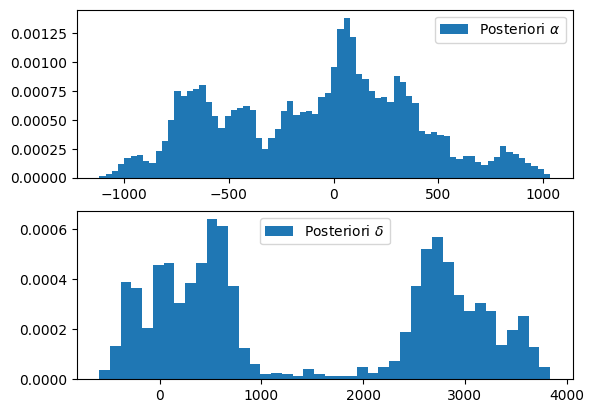

In [19]:
#propriété des estimations

alpha = chain[:, 0]
delta = chain[:, 1]

fig, ax = plt.subplot_mosaic([["A", "A"],
                              ["B", "B"]])
ax["A"].hist(alpha[1000:], bins= 'auto', label= r"Posteriori $\alpha$", density = True);
ax["A"].legend()
ax["B"].hist(delta[1000:], bins= 'auto', label= r"Posteriori $\delta$", density = True)
ax["B"].legend();

In [20]:
print(f"La valeur moyenne de alpha est {round(alpha[1000:].mean(),4)} et son ecart-type est {round(alpha[1000:].std(),4)}")
print(f"La valeur moyenne de delta est {round(delta[1000:].mean(),4)} et son ecart-type est {round(delta[1000:].std(),4)}")

La valeur moyenne de alpha est -80.2905 et son ecart-type est 457.6265
La valeur moyenne de delta est 1473.5819 et son ecart-type est 1369.5462


In [21]:
estimate_p = (1/(1+ np.exp(alpha[1000:]))).mean()
estimate_theta = (1/(1+ np.exp(delta[1000:]))).mean()
print("theta :", estimate_theta)

theta : 0.14821488169974528


/var/folders/gb/qczdw8wn6lv1b0m0dm46j07h0000gn/T/ipykernel_66631/2358937618.py:1: RuntimeWarning: overflow encountered in exp
  estimate_p = (1/(1+ np.exp(alpha[1000:]))).mean()
/var/folders/gb/qczdw8wn6lv1b0m0dm46j07h0000gn/T/ipykernel_66631/2358937618.py:2: RuntimeWarning: overflow encountered in exp
  estimate_theta = (1/(1+ np.exp(delta[1000:]))).mean()
